In [1]:
import numpy as np
import py

from py.simulation import *
from py.estimation import *
from py.features import *
from py.utils import *
from py.prep_data import *
from scipy.optimize import minimize
from importlib import reload

from matplotlib import pyplot as plt

In [2]:
rank_threshold = 5
t_start = 0

feature_fun = degree_quadratic_feature

In [3]:
T, timesteps, labels = prep_newcomb_frat('data/newcomb_frat/', rank_threshold = rank_threshold)
T, timesteps, A0, n_obs = initial_condition(T, timesteps, t_start = t_start)

n = T.shape[1]

In [4]:
pars = ML(T, 
          A0, 
          feature_fun = feature_fun, 
          bounds = [(-.2, 1)],
          dim = 2)

computing memory hyperparameter lambda
computing parameter vector beta


In [5]:
pars

{'lam': array([0.37652808]),
 'beta': array([ 1.04308231, -0.31169788]),
 'beta_stderr': array([0.04645571, 0.04192123]),
 'LL': -3836.31404373479}

/Users/philchodrow/Dropbox (MIT)/projects/!side_projects/prestige_reinforcement/py/features.py:97: RuntimeWarning: invalid value encountered in sqrt
  S[0] = np.sqrt(A.sum(axis = 0) + d0)
/Users/philchodrow/Dropbox (MIT)/projects/!side_projects/prestige_reinforcement/py/features.py:13: RuntimeWarning: overflow encountered in exp
  gamma = np.exp(phi)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Library/Frameworks/Pyth

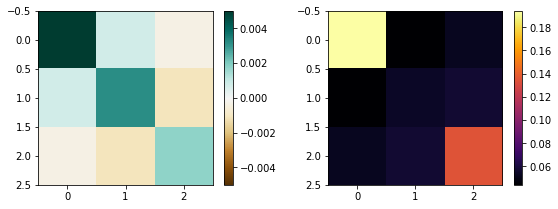

In [6]:
H = estimate_hessian(T, A0, feature_fun, pars['lam'], pars['beta'])
V = np.linalg.inv(-H)
V # covariance matrix

p = np.concatenate((pars['lam'], pars['beta']))

fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(121)
im = ax.imshow(V, cmap = 'BrBG', vmin = -0.005, vmax = 0.005) # estimated covariance matrix
plt.colorbar(im)
ax = fig.add_subplot(122)
im = ax.imshow(np.sqrt(V/np.outer(p,p)), cmap = 'inferno')    # coefficient of variation
plt.colorbar(im)
plt.tight_layout()

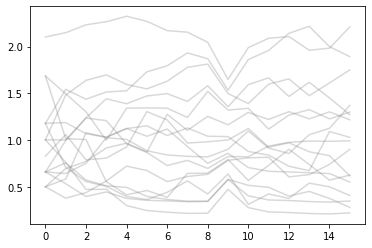

In [11]:
A = state_matrix(T, A0 = A0, lam = pars['lam'])
S = feature_fun(A)

GAMMA = softmax(S, pars['beta']).sum(axis = 1)

# GAMMA = np.sort(GAMMA, axis = 1)
p = plt.plot(GAMMA, color = 'grey', alpha = .3)

(-0.5, 16.5, 16.5, -0.5)

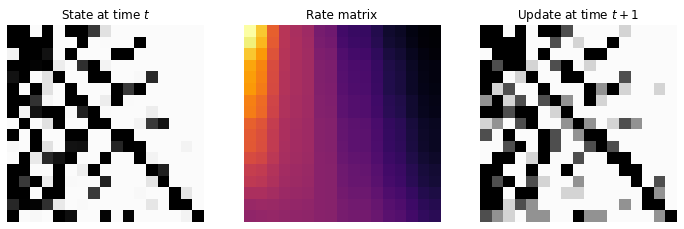

In [12]:
# snapshot of the state and cumulative hiring matrix at specified time i

i = 10

V = softmax(S, pars['beta'])[i]

fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(131)
ax.imshow(np.ones_like(A[i]), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(A[i], -V.sum(axis = 0)), cmap = 'Greys', alpha = .99)
ax.set(title = 'State at time $t$')
ax.axis('off')

ax = fig.add_subplot(132)
# plt.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1)
ax.imshow(matrix_sort(V, -V.sum(axis = 0)), alpha = .995, cmap = 'inferno')
ax.set(title = 'Rate matrix')
plt.gca().axis('off')

ax = fig.add_subplot(133)
ax.imshow(np.ones_like(T[i]), cmap = 'Greys',  vmin = 0, alpha = 1)
ax.imshow(matrix_sort(T[i+4]-T[i], -GAMMA[i]),  cmap = 'Greys', alpha = .99)
ax.set(title = 'Update at time $t+1$')
ax.axis('off')
# plt.colorbar()
# check: is it correct that the agents endorse themselves in this data set?

In [13]:
grid = 21
M = np.zeros((grid, grid))

beta = pars['beta']

X = np.linspace(beta[0] - 1, beta[0] + 1, grid)
Y = np.linspace(beta[1] - 1, beta[1] + 1, grid)
x, y = np.meshgrid(X, Y)
for i in range(grid):
    for j in range(grid):
        M[i,j] = ll(T, S, beta = np.array([x[i,j], y[i,j]]))

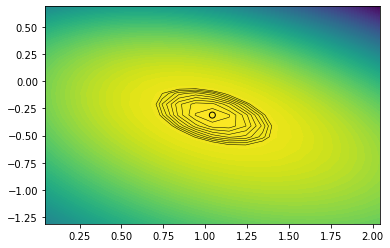

In [14]:
plt.contourf(x, y, M, levels = 100)

plt.contour(x, y, M, 
            levels = np.linspace(M.max() - 20, M.max(), 10),
               linewidths = .5, 
               colors = 'black', 
               linestyles = 'solid')

ix = np.where(M == M.max())
plt.scatter(X[ix[1]], Y[ix[0]], color = 'black', facecolor='none')
# plt.colorbar()

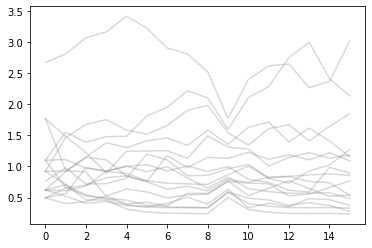

In [15]:
# these are the *rank components* of gamma 
V = np.exp(S[:,0,:,:]*beta[0])
V = V/V.sum(axis = 2)[:,:,np.newaxis]
pl = plt.plot(V.sum(axis = 1),color = 'grey', alpha = .3)

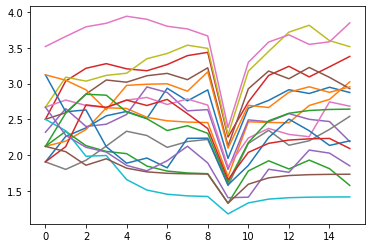

In [16]:
plt.plot(S[:,0,:,:][:,0,:])